<a href="https://colab.research.google.com/github/adrielsvr/Sentimen-Analisis-Publik-terhadap-Transportasi-Kereta-di-Jakarta/blob/main/Pemodelan/Pemodelan_Data_LRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from google.colab import drive
from collections import Counter
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_lrt = '/content/drive/MyDrive/Tugas Akhir/Dataset Twitter/Dataset/Data_LRT_Label_Sentiment.csv'
data_lrt = pd.read_csv(path_lrt)
data_lrt.head()

,full_text,clean_text,normalisasi,tokenized_text,stopwords_removal,stemming,polarity_score,sentiment
0,LRT Jabodebek siap mengatasi kemacetan. Yuk ce...,lrt jabodebek siap mengatasi kemacetan yuk cek...,lrt jabodebek siap mengatasi kemacetan ayo cek...,"['lrt', 'jabodebek', 'siap', 'mengatasi', 'kem...","['lrt', 'jabodebek', 'siap', 'mengatasi', 'kem...",lrt jabodebek siap atas macet ayo cek cara nai...,-6,Negatif
1,Dewi Perssik Sebut Nikita Mirzani Jualan Apem ...,dewi perssik sebut nikita mirzani jualan apem ...,dewi perssik sebut nikita mirzani jualan apem ...,"['dewi', 'perssik', 'sebut', 'nikita', 'mirzan...","['dewi', 'perssik', 'sebut', 'nikita', 'mirzan...",dewi perssik sebut nikita mirzani jual apem ir...,-4,Negatif
2,"Viral Rok Model Melorot, Rachel Vennya Tampil ...",viral rok model melorot rachel vennya tampil b...,viral rok model melorot rachel vennya tampil b...,"['viral', 'rok', 'model', 'melorot', 'rachel',...","['viral', 'rok', 'model', 'melorot', 'rachel',...",viral rok model lorot rachel vennya tampil buk...,-12,Negatif
3,Kebangun abis mimpi naik LRT jakarta nyampe di...,kebangun abis mimpi naik lrt jakarta nyampe di...,kebangun habis mimpi naik lrt jakarta nyampe d...,"['kebangun', 'habis', 'mimpi', 'naik', 'lrt', ...","['kebangun', 'habis', 'mimpi', 'naik', 'lrt', ...",bangun habis mimpi naik lrt jakarta nyampe sta...,0,Netral
4,Saat @erickthohir mendampingi presiden Jokowi ...,saat mendampingi presiden jokowi dalam meresmi...,saat mendampingi presiden jokowi dalam meresmi...,"['saat', 'mendampingi', 'presiden', 'jokowi', ...","['mendampingi', 'presiden', 'jokowi', 'meresmi...",damping presiden jokowi resmi kereta api ringa...,-1,Negatif


## LRT

In [ ]:
tfidf = TfidfVectorizer(max_features=2500, min_df=8, max_df=0.7)
X = tfidf.fit_transform(data_lrt['stemming']).toarray()
y = np.array(data_lrt['sentiment'])

encode = LabelEncoder()
y = encode.fit_transform(y)

- 0 --> Sentimen Negatif
- 1 --> Sentimen Netral
- 2 --> Sentimen Positif

In [ ]:
# prompt: smote

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset shape:", Counter(y))
print("Resampled dataset shape:", Counter(y_resampled))


Original dataset shape: Counter({0: 1681, 2: 370, 1: 131})
Resampled dataset shape: Counter({0: 1681, 1: 1681, 2: 1681})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [ ]:
# prompt: menghitung jumlah data train dan data test jika perbandingannya seperti berikut : 70:30, 60:40, 80:20 dan 90:10. buatkan dalam bentuk tabel

import pandas as pd

# Data total
total_data = len(data_lrt)

# Rasio yang akan diuji
ratios = [(0.7, 0.3), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]

# Membuat tabel
table_data = []
for train_ratio, test_ratio in ratios:
  train_count = int(total_data * train_ratio)
  test_count = int(total_data * test_ratio)
  table_data.append([f"{train_ratio*100:.0f}:{test_ratio*100:.0f}", train_count, test_count])


df_table = pd.DataFrame(table_data, columns=['Ratio Train:Test', 'Jumlah Data Train', 'Jumlah Data Test'])
df_table

,Ratio Train:Test,Jumlah Data Train,Jumlah Data Test
0,70:30,1527,654
1,60:40,1309,872
2,80:20,1745,436
3,90:10,1963,218


Parameter terbaik: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
from sklearn.svm import SVC

# Inisialisasi model SVM
svc = SVC(kernel='rbf', C=10, gamma=1, probability=True)

# Latih model
model = svc.fit(X_train, y_train)
y_pred_svm = model.predict(X_test)

# Evaluasi model
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       526
           1       0.89      1.00      0.94       483
           2       0.98      0.87      0.92       504

    accuracy                           0.94      1513
   macro avg       0.95      0.94      0.94      1513
weighted avg       0.95      0.94      0.94      1513



In [ ]:
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print(f'Accuracy Score   : {(acc_svm * 100):.2f}')
print(f'Precision Score  : {(prec_svm * 100):.2f}')
print(f'Recall Score     : {(recall_svm * 100):.2f}')
print(f'f1-score         : {(f1_svm * 100):.2f}')

Accuracy Score   : 94.45
Precision Score  : 94.77
Recall Score     : 94.45
f1-score         : 94.40


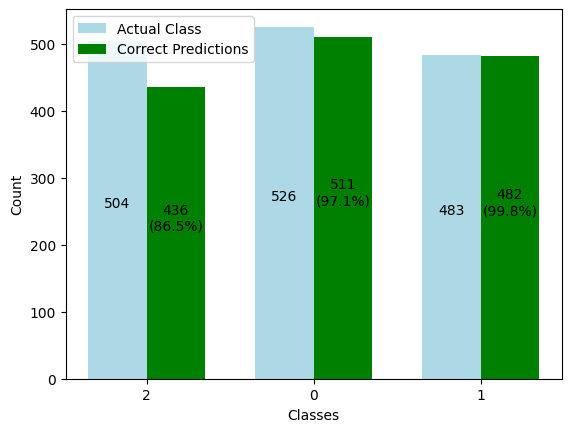

In [ ]:
# Hitung jumlah prediksi yang benar dan total untuk setiap kelas
correct_predictions = Counter()
total_predictions = Counter()

for true, pred in zip(y_test, y_pred_svm):
    total_predictions[true] += 1
    if true == pred:
        correct_predictions[true] += 1

# Buat plot batang
labels = list(total_predictions.keys())
total_counts = list(total_predictions.values())
correct_counts = [correct_predictions[label] for label in labels]

fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(labels))

bar1 = ax.bar(index, total_counts, bar_width, label='Actual Class', color='lightblue')
bar2 = ax.bar(index + bar_width, correct_counts, bar_width, label='Correct Predictions', color='green')

# Tambahkan label dan persentase
for i, (total, correct) in enumerate(zip(total_counts, correct_counts)):
    ax.text(i, total/2, str(total), ha='center', va='bottom')
    percentage = (correct / total) * 100 if total > 0 else 0
    ax.text(i + bar_width, correct/2, f'{correct}\n({percentage:.1f}%)', ha='center', va='bottom')

ax.set_xlabel('Classes')
ax.set_ylabel('Count')
# ax.set_title('Prediction Accuracy by Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

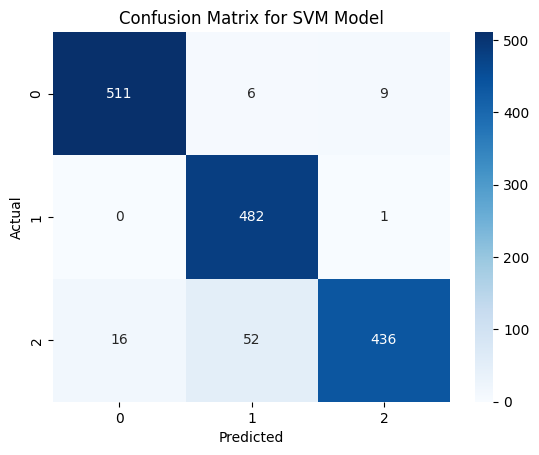

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM Model')
plt.show()

Parameter terbaik: {'C': 10, 'solver': 'saga', 'tol': 0.01}

In [ ]:
from sklearn.linear_model import LogisticRegression

# Inisialisasi model Logistic Regression
logreg = LogisticRegression(C=10, solver='saga', tol=0.01)

# Latih model
model_logreg = logreg.fit(X_train, y_train)
y_pred_logreg = model_logreg.predict(X_test)

# Evaluasi model
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       526
           1       0.83      0.99      0.90       483
           2       0.91      0.87      0.89       504

    accuracy                           0.90      1513
   macro avg       0.91      0.90      0.90      1513
weighted avg       0.91      0.90      0.90      1513



In [ ]:
acc_logreg = accuracy_score(y_test, y_pred_logreg)
prec_logreg = precision_score(y_test, y_pred_logreg, average='weighted')
recall_logreg = recall_score(y_test, y_pred_logreg, average='weighted')
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')

print(f'Accuracy Score   : {(acc_logreg * 100):.2f}')
print(f'Precision Score  : {(prec_logreg * 100):.2f}')
print(f'Recall Score     : {(recall_logreg * 100):.2f}')
print(f'f1-score         : {(f1_logreg * 100):.2f}')

Accuracy Score   : 83.11
Precision Score  : 82.36
Recall Score     : 83.11
f1-score         : 82.70


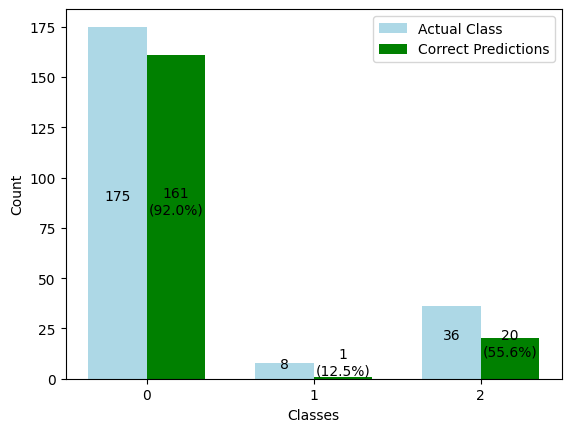

In [ ]:
# Hitung jumlah prediksi yang benar dan total untuk setiap kelas
correct_predictions = Counter()
total_predictions = Counter()

for true, pred in zip(y_test, y_pred_logreg):
    total_predictions[true] += 1
    if true == pred:
        correct_predictions[true] += 1

# Buat plot batang
labels = list(total_predictions.keys())
total_counts = list(total_predictions.values())
correct_counts = [correct_predictions[label] for label in labels]

fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(labels))

bar1 = ax.bar(index, total_counts, bar_width, label='Actual Class', color='lightblue')
bar2 = ax.bar(index + bar_width, correct_counts, bar_width, label='Correct Predictions', color='green')

# Tambahkan label dan persentase
for i, (total, correct) in enumerate(zip(total_counts, correct_counts)):
    ax.text(i, total/2, str(total), ha='center', va='bottom')
    percentage = (correct / total) * 100 if total > 0 else 0
    ax.text(i + bar_width, correct/2, f'{correct}\n({percentage:.1f}%)', ha='center', va='bottom')

ax.set_xlabel('Classes')
ax.set_ylabel('Count')
# ax.set_title('Prediction Accuracy by Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Model')

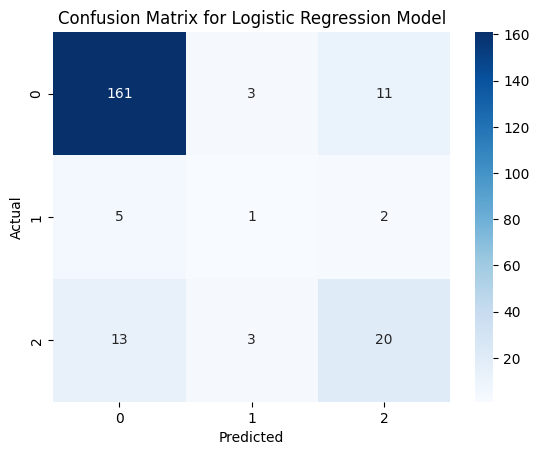

In [ ]:
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')

In [ ]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
# Reshape data for CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Initialize CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=1))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(y_train_cat.shape[1], activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_cnn, y_train_cat, epochs=10, batch_size=64, verbose=1)

# Evaluate the model
_, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"CNN Accuracy: {cnn_acc * 100:.2f}%")

# Make predictions
cnn_pred = cnn_model.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_pred, axis=1)
cnn_val_classes = np.argmax(y_test_cat, axis=1)

# Calculate metrics
cnn_accuracy = accuracy_score(cnn_val_classes, cnn_pred_classes)
cnn_precision_weighted = precision_score(np.argmax(y_test_cat, axis=1), cnn_pred_classes, average='weighted')
cnn_recall_weighted = recall_score(np.argmax(y_test_cat, axis=1), cnn_pred_classes, average='weighted')
cnn_f1_weighted = f1_score(np.argmax(y_test_cat, axis=1), cnn_pred_classes, average='weighted')

print(classification_report(y_test, cnn_pred_classes))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.6972 - loss: 0.7924
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.7880 - loss: 0.5079
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8591 - loss: 0.3529
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9224 - loss: 0.2255
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.9504 - loss: 0.1574
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.9670 - loss: 0.1019
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.9818 - loss: 0.0759
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.9870 - loss: 0.0538
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.9907 - loss: 0.0382
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9926 - loss: 0.0284
CNN Accuracy: 81.74%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
              precision    recall  f1-score   support

           0       0.91      0.90   

In [ ]:
acc_cnn = accuracy_score(y_test, cnn_pred_classes)
prec_cnn = precision_score(y_test, cnn_pred_classes, average='weighted')
recall_cnn = recall_score(y_test, cnn_pred_classes, average='weighted')
f1_cnn = f1_score(y_test, cnn_pred_classes, average='weighted')

print(f'Accuracy Score   : {(acc_cnn * 100):.2f}')
print(f'Precision Score  : {(prec_cnn * 100):.2f}')
print(f'Recall Score     : {(recall_cnn * 100):.2f}')
print(f'f1-score         : {(f1_cnn * 100):.2f}')

Accuracy Score   : 81.74
Precision Score  : 82.86
Recall Score     : 81.74
f1-score         : 82.28


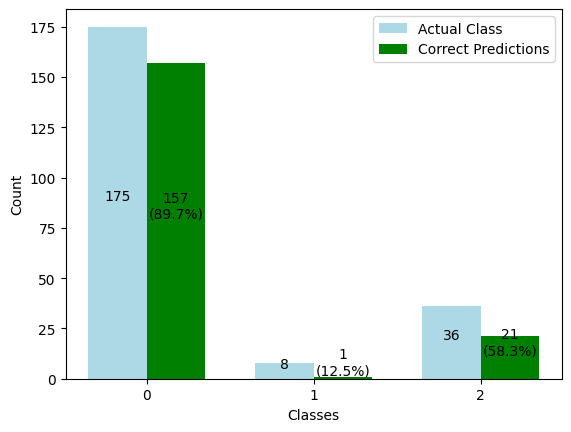

In [ ]:
# Hitung jumlah prediksi yang benar dan total untuk setiap kelas
correct_predictions = Counter()
total_predictions = Counter()

for true, pred in zip(y_test, cnn_pred_classes):
    total_predictions[true] += 1
    if true == pred:
        correct_predictions[true] += 1

# Buat plot batang
labels = list(total_predictions.keys())
total_counts = list(total_predictions.values())
correct_counts = [correct_predictions[label] for label in labels]

fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(labels))

bar1 = ax.bar(index, total_counts, bar_width, label='Actual Class', color='lightblue')
bar2 = ax.bar(index + bar_width, correct_counts, bar_width, label='Correct Predictions', color='green')

# Tambahkan label dan persentase
for i, (total, correct) in enumerate(zip(total_counts, correct_counts)):
    ax.text(i, total/2, str(total), ha='center', va='bottom')
    percentage = (correct / total) * 100 if total > 0 else 0
    ax.text(i + bar_width, correct/2, f'{correct}\n({percentage:.1f}%)', ha='center', va='bottom')

ax.set_xlabel('Classes')
ax.set_ylabel('Count')
# ax.set_title('Prediction Accuracy by Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Text(0.5, 1.0, 'Confusion Matrix for CNN Model')

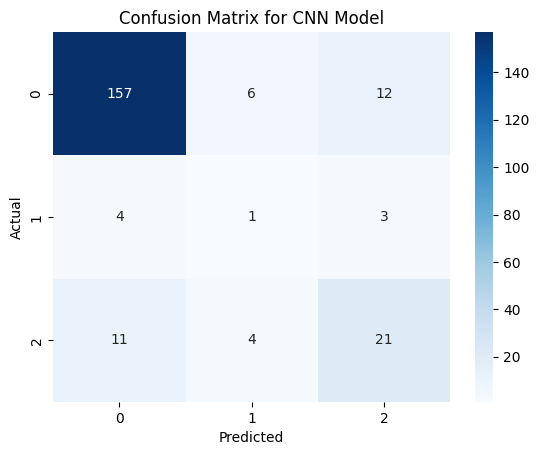

In [ ]:
cm = confusion_matrix(cnn_val_classes, cnn_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CNN Model')

In [ ]:
svm_proba = svc.predict_proba(X_test)
logreg_proba = logreg.predict_proba(X_test)
cnn_proba = cnn_pred
avg_proba = (svm_proba + logreg_proba + cnn_proba) / 3

avg_proba = (svm_proba + logreg_proba + cnn_proba) / 3
soft_voting = np.argmax(avg_proba, axis=1)

In [ ]:
# Hybrid model with voting
final_pred = []

for i in range(len(X_test)):
    if y_pred_svm[i] == y_pred_logreg[i] or y_pred_svm[i] == cnn_pred_classes[i]:
        final_pred.append(y_pred_svm[i])
    elif y_pred_logreg[i] == cnn_pred_classes[i]:
        final_pred.append(y_pred_logreg[i])
    else:
        final_pred.append(soft_voting[i])

# Menampilkan laporan klasifikasi dari model hybrid
print("Hybrid Model Classification Report:")
print(classification_report(y_test, final_pred))

Hybrid Model Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       175
           1       0.14      0.12      0.13         8
           2       0.67      0.56      0.61        36

    accuracy                           0.85       219
   macro avg       0.57      0.54      0.55       219
weighted avg       0.84      0.85      0.84       219



In [ ]:
acc_hybrid = accuracy_score(y_test, final_pred)
prec_hybrid = precision_score(y_test, final_pred, average='weighted')
recall_hybrid = recall_score(y_test, final_pred, average='weighted')
f1_hybrid = f1_score(y_test, final_pred, average='weighted')

print(f'Accuracy Score   : {(acc_hybrid * 100):.2f}')
print(f'Precision Score  : {(prec_hybrid * 100):.2f}')
print(f'Recall Score     : {(recall_hybrid * 100):.2f}')
print(f'f1-score         : {(f1_hybrid * 100):.2f}')

Accuracy Score   : 84.93
Precision Score  : 83.93
Recall Score     : 84.93
f1-score         : 84.31


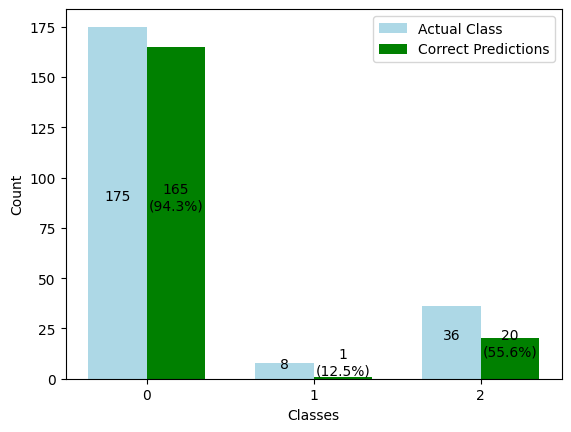

In [ ]:
# Hitung jumlah prediksi yang benar dan total untuk setiap kelas
correct_predictions = Counter()
total_predictions = Counter()

for true, pred in zip(y_test, final_pred):
    total_predictions[true] += 1
    if true == pred:
        correct_predictions[true] += 1

# Buat plot batang
labels = list(total_predictions.keys())
total_counts = list(total_predictions.values())
correct_counts = [correct_predictions[label] for label in labels]

fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(labels))

bar1 = ax.bar(index, total_counts, bar_width, label='Actual Class', color='lightblue')
bar2 = ax.bar(index + bar_width, correct_counts, bar_width, label='Correct Predictions', color='green')

# Tambahkan label dan persentase
for i, (total, correct) in enumerate(zip(total_counts, correct_counts)):
    ax.text(i, total/2, str(total), ha='center', va='bottom')
    percentage = (correct / total) * 100 if total > 0 else 0
    ax.text(i + bar_width, correct/2, f'{correct}\n({percentage:.1f}%)', ha='center', va='bottom')

ax.set_xlabel('Classes')
ax.set_ylabel('Count')
# ax.set_title('Prediction Accuracy by Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Text(0.5, 1.0, 'Confusion Matrix for Hybrid Model')

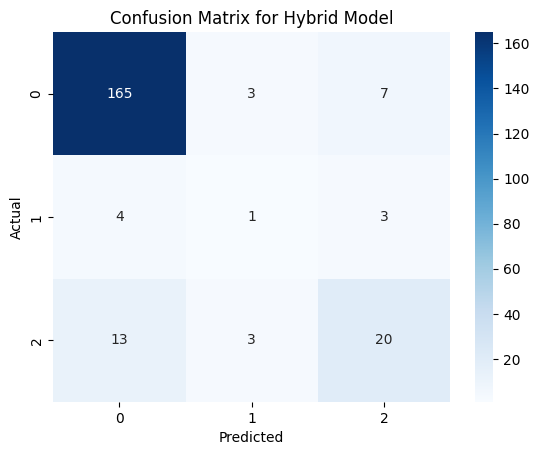

In [ ]:
cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hybrid Model')

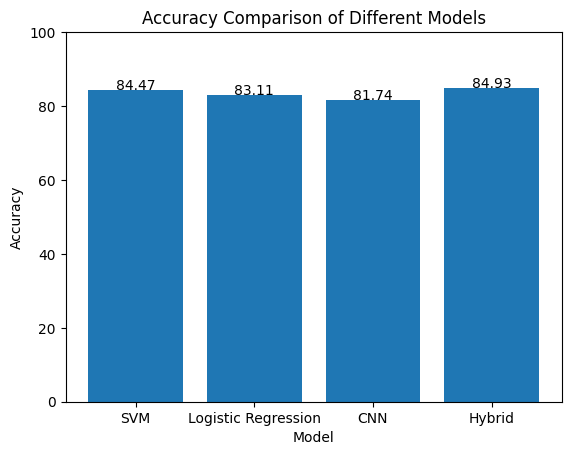

In [ ]:
# Data for the bar chart
models = ['SVM', 'Logistic Regression', 'CNN', 'Hybrid']
accuracies = [accuracy_score(y_test, y_pred_svm)*100,
              accuracy_score(y_test, y_pred_logreg)*100,
              cnn_acc*100,
              accuracy_score(y_test, final_pred)*100]

# Create the bar chart
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim([0, 100])  # Set y-axis limits for better visualization

# Display the values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.show()


In [ ]:
count_correct = []
for i in range (len(y_test)):
  if y_test[i] == final_pred[i]:
    count_correct.append(1)
  else:
    count_correct.append(0)

acc_conf = sum(count_correct)/len(y_test)

if acc_conf == acc_hybrid :
  print('accuracy hybrid model and confusion matrix is match')
else:
  print('accuracy hybrid model and confusion matrix is not match')

accuracy hybrid model and confusion matrix is match


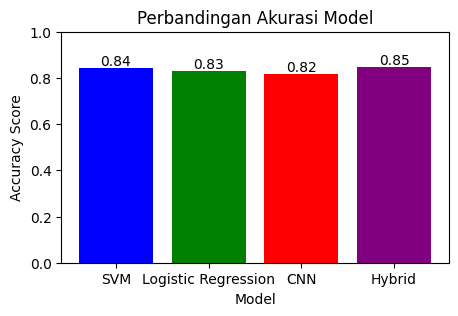

In [ ]:
# Data Akurasi
models = ['SVM', 'Logistic Regression', 'CNN', 'Hybrid']
accuracy_scores = [acc_svm, acc_logreg, acc_cnn, acc_hybrid]

# Membuat plot batang
plt.figure(figsize=(5, 3))
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 1)  # Set batas sumbu y dari 0 hingga 1

# Menampilkan nilai akurasi di atas setiap batang
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.show()

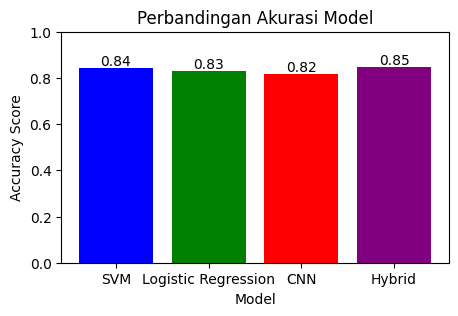

In [ ]:
# Data Akurasi
models = ['SVM', 'Logistic Regression', 'CNN', 'Hybrid']
accuracy_scores = [acc_svm, acc_logreg, acc_cnn, acc_hybrid]

# Membuat plot batang
plt.figure(figsize=(5, 3))
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 1)  # Set batas sumbu y dari 0 hingga 1

# Menampilkan nilai akurasi di atas setiap batang
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.show()

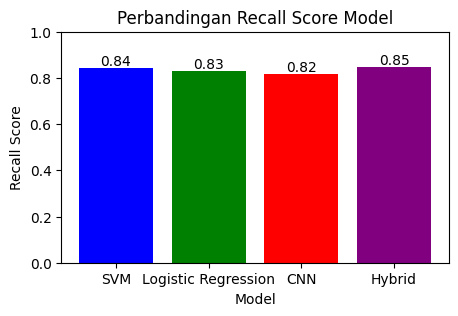

In [ ]:
# prompt: buatkan perbandingan recall score dari 4 model

import matplotlib.pyplot as plt
# Data Recall Score
models = ['SVM', 'Logistic Regression', 'CNN', 'Hybrid']
recall_scores = [recall_svm, recall_logreg, recall_cnn, recall_hybrid]

# Membuat plot batang
plt.figure(figsize=(5, 3))
plt.bar(models, recall_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Recall Score')
plt.title('Perbandingan Recall Score Model')
plt.ylim(0, 1)  # Set batas sumbu y dari 0 hingga 1

# Menampilkan nilai recall score di atas setiap batang
for i, score in enumerate(recall_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.show()

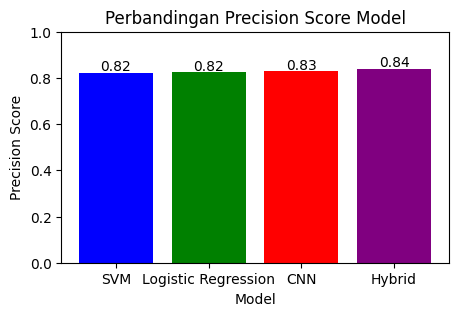

In [ ]:
# prompt: perbandingan precision 4 model

import matplotlib.pyplot as plt
# Data Precision Score
models = ['SVM', 'Logistic Regression', 'CNN', 'Hybrid']
precision_scores = [prec_svm, prec_logreg, prec_cnn, prec_hybrid]

# Membuat plot batang
plt.figure(figsize=(5, 3))
plt.bar(models, precision_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Precision Score')
plt.title('Perbandingan Precision Score Model')
plt.ylim(0, 1)  # Set batas sumbu y dari 0 hingga 1

# Menampilkan nilai precision score di atas setiap batang
for i, score in enumerate(precision_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.show()

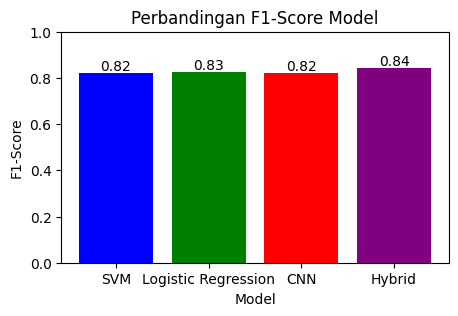

In [ ]:
# prompt: perbandingan f1 score 4 model

import matplotlib.pyplot as plt
# Data F1-Score
models = ['SVM', 'Logistic Regression', 'CNN', 'Hybrid']
f1_scores = [f1_svm, f1_logreg, f1_cnn, f1_hybrid]

# Membuat plot batang
plt.figure(figsize=(5, 3))
plt.bar(models, f1_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score Model')
plt.ylim(0, 1)  # Set batas sumbu y dari 0 hingga 1

# Menampilkan nilai F1-Score di atas setiap batang
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.show()

In [ ]:
print('Akurasi')
print(f'SVM Accuracy : {acc_svm:.2f}')
print(f'Logistic Regression Accuracy : {acc_logreg:.2f}')
print(f'CNN Accuracy : {acc_cnn:.2f}')
print(f'Hybrid Model Accuracy : {acc_hybrid:.2f}\n')
print('precision')
print(f'SVM Precision : {prec_svm:.2f}')
print(f'Logistic Regression Precision : {prec_logreg:.2f}')
print(f'CNN Precision : {prec_cnn:.2f}')
print(f'Hybrid Model Precision : {prec_hybrid:.2f}\n')
print('recall')
print(f'SVM Recall : {recall_svm:.2f}')
print(f'Logistic Regression Recall : {recall_logreg:.2f}')
print(f'CNN Recall : {recall_cnn:.2f}')
print(f'Hybrid Model Recall : {recall_hybrid:.2f}\n')
print('f1-score')
print(f'SVM F1-Score : {f1_svm:.2f}')
print(f'Logistic Regression F1-Score : {f1_logreg:.2f}')
print(f'CNN F1-Score : {f1_cnn:.2f}')
print(f'Hybrid Model F1-Score : {f1_hybrid:.2f}')

Akurasi
SVM Accuracy : 0.84
Logistic Regression Accuracy : 0.83
CNN Accuracy : 0.82
Hybrid Model Accuracy : 0.85

precision
SVM Precision : 0.82
Logistic Regression Precision : 0.82
CNN Precision : 0.83
Hybrid Model Precision : 0.84

recall
SVM Recall : 0.84
Logistic Regression Recall : 0.83
CNN Recall : 0.82
Hybrid Model Recall : 0.85

f1-score
SVM F1-Score : 0.82
Logistic Regression F1-Score : 0.83
CNN F1-Score : 0.82
Hybrid Model F1-Score : 0.84
